Skimming:<br>Part1.Pycaret initial data exploration<br>Part2.Linear Regression (Simple/Lasso/Ridge) with KFold in-sample analysis <br>Part3.Random Forest: Parametre Tuning and KFold in-sample analysis<br>Part4.Gradient Boosting: Parametre Tuning and KFold in-sample analysis<br>Part5.SVM(Kernel=linear/radial/polynomial)<br>Part6.Sales Prediction, inventory Decision and out-of-sample Profit with the best fit model
    

In [1]:
from pycaret.regression import *

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('Data-train.csv',index_col=0)
data=data.dropna()
data.head()

,productID,brandID,attribute1,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,weekday,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales
0,6,24,3.0,100.0,2418.0,278.97561,216.768293,56.928571,5,31.694915,0.338983,2.929825,0.431034,0.269841,2.120690,3.079365,1.943396,82
1,47,25,4.0,100.0,1723.0,79.90000,59.233333,49.285714,6,30.652174,0.217391,2.928571,0.604651,0.191489,2.302326,2.446809,2.093023,48
2,6,24,3.0,100.0,1666.0,298.00000,214.410714,48.857143,4,31.370370,0.148148,2.941176,0.519231,0.357143,2.153846,2.839286,2.104167,56
3,48,25,3.0,80.0,386.0,69.90000,40.664706,19.714286,4,32.222222,0.333333,3.111111,0.333333,0.272727,2.444444,2.700000,2.888889,17
4,47,25,4.0,100.0,1419.0,79.90000,58.703279,66.214286,4,31.020408,0.183673,2.978723,0.425532,0.218182,2.468085,2.490909,2.042553,61


### setting up data for pycaret

In [4]:
clf = setup(data=data,target='sales',session_id=2000,categorical_features =['productID','brandID','attribute1','attribute2'])

 
Setup Succesfully Completed.


,Description,Value
0,session_id,2000
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2491, 18)"
4,Missing Values,False
5,Numeric Features,12
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


### compare_models gives different models' results based on MSE, R2 and other performance metrics.

In [5]:
best=compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,15.57,1520,37.54,0.8169,0.4728,0.5259,2.087
1,Extra Trees Regressor,17.22,1749,40.66,0.7768,0.5,0.6269,0.3813
2,Gradient Boosting Regressor,17.09,1759,40.22,0.7672,0.5501,0.6471,0.5198
3,Extreme Gradient Boosting,17.37,2027,43.16,0.7549,0.5008,0.5283,1.004
4,Light Gradient Boosting Machine,17.83,2026,43.52,0.7546,0.4947,0.5609,0.1277
5,Random Forest,17.48,1942,42.39,0.7545,0.5013,0.598,0.456
6,Random Sample Consensus,19.94,2330,45.68,0.6853,0.6647,1.002,0.9014
7,Huber Regressor,19.2,2346,45.59,0.6846,0.6144,0.7948,0.0931
8,TheilSen Regressor,21.58,2395,45.54,0.6694,0.7868,1.581,11.72
9,K Neighbors Regressor,21.72,2590,49.53,0.6653,0.5864,0.726,0.0096


### Based on Pycaret results, GBR gave the 3rd best MSE. RF, LR, Lasso and Ridge were also used for comparison.

# Linear Regression

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel

## Read data

In [2]:
data=pd.read_csv('Data-train.csv',index_col=0)
data.head()

,productID,brandID,attribute1,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,weekday,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales
0,6,24,3.0,100.0,2418.0,278.97561,216.768293,56.928571,5,31.694915,0.338983,2.929825,0.431034,0.269841,2.120690,3.079365,1.943396,82
1,47,25,4.0,100.0,1723.0,79.90000,59.233333,49.285714,6,30.652174,0.217391,2.928571,0.604651,0.191489,2.302326,2.446809,2.093023,48
2,6,24,3.0,100.0,1666.0,298.00000,214.410714,48.857143,4,31.370370,0.148148,2.941176,0.519231,0.357143,2.153846,2.839286,2.104167,56
3,48,25,3.0,80.0,386.0,69.90000,40.664706,19.714286,4,32.222222,0.333333,3.111111,0.333333,0.272727,2.444444,2.700000,2.888889,17
4,47,25,4.0,100.0,1419.0,79.90000,58.703279,66.214286,4,31.020408,0.183673,2.978723,0.425532,0.218182,2.468085,2.490909,2.042553,61


In [3]:
data['discount']=1-(data['avgOriginalUnitPrice']-data['avgFinalUnitPrice'])/data['avgOriginalUnitPrice']
data = data.drop(columns=['avgFinalUnitPrice','avgOriginalUnitPrice'])

In [4]:
data.productID = data.productID.astype('category')
data.attribute1 = data.attribute1.astype('category')
data.attribute2 = data.attribute2.astype('category')
data['weekday'] = data.apply(lambda x: data['weekday']<5)
data.weekday = data.weekday.astype('category')
data['sales14click']=data['clickVolume']*data['ma14SalesVolume']
data.head()

,productID,brandID,attribute1,attribute2,clickVolume,ma14SalesVolume,weekday,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales,discount,sales14click
0,6,24,3.0,100.0,2418.0,56.928571,False,31.694915,0.338983,2.929825,0.431034,0.269841,2.120690,3.079365,1.943396,82,0.777015,137653.285714
1,47,25,4.0,100.0,1723.0,49.285714,False,30.652174,0.217391,2.928571,0.604651,0.191489,2.302326,2.446809,2.093023,48,0.741343,84919.285714
2,6,24,3.0,100.0,1666.0,48.857143,True,31.370370,0.148148,2.941176,0.519231,0.357143,2.153846,2.839286,2.104167,56,0.719499,81396.000000
3,48,25,3.0,80.0,386.0,19.714286,True,32.222222,0.333333,3.111111,0.333333,0.272727,2.444444,2.700000,2.888889,17,0.581755,7609.714286
4,47,25,4.0,100.0,1419.0,66.214286,True,31.020408,0.183673,2.978723,0.425532,0.218182,2.468085,2.490909,2.042553,61,0.734709,93958.071429


In [5]:
data.corr()

,brandID,clickVolume,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales,discount,sales14click
brandID,1.000000,0.029776,0.014146,-0.096038,0.039874,0.067072,-0.078445,0.069359,-0.039329,0.117087,-0.062888,0.005926,-0.262764,0.052846
clickVolume,0.029776,1.000000,0.723921,-0.054060,-0.005997,-0.062936,-0.023115,0.006499,0.012437,-0.041505,0.027674,0.809854,-0.096653,0.812937
ma14SalesVolume,0.014146,0.723921,1.000000,-0.058149,-0.000779,-0.050351,-0.042011,-0.008243,0.005106,-0.056549,0.006853,0.691496,-0.074537,0.789413
meanAge,-0.096038,-0.054060,-0.058149,1.000000,0.054092,0.065548,0.462438,0.040562,-0.068855,0.077794,-0.075656,-0.051563,0.099710,-0.046584
gender,0.039874,-0.005997,-0.000779,0.054092,1.000000,-0.035080,-0.049387,0.119951,-0.027012,0.078634,0.032138,-0.008977,0.064886,0.000517
meanEducation,0.067072,-0.062936,-0.050351,0.065548,-0.035080,1.000000,0.270954,0.429008,-0.239046,0.425385,-0.335881,-0.027492,-0.128537,-0.017871
maritalStatus,-0.078445,-0.023115,-0.042011,0.462438,-0.049387,0.270954,1.000000,0.199591,-0.137708,0.197312,-0.086755,-0.017169,-0.000277,-0.035643
plus,0.069359,0.006499,-0.008243,0.040562,0.119951,0.429008,0.199591,1.000000,-0.287577,0.245385,-0.205512,0.002568,-0.149352,0.012854
meanPurchasePower,-0.039329,0.012437,0.005106,-0.068855,-0.027012,-0.239046,-0.137708,-0.287577,1.000000,-0.238552,0.124670,0.032877,-0.023385,-0.012496
meanUserLevel,0.117087,-0.041505,-0.056549,0.077794,0.078634,0.425385,0.197312,0.245385,-0.238552,1.000000,-0.217448,-0.047555,0.049777,-0.027900


## No standardization Simple Linear Regression (OLS)

In [6]:
X=data.drop('sales', axis=1)
y=data.sales
#split data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=42)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
#fit the model
#MSE
lr=LinearRegression()
lr.fit(X_train, y_train)
MSE(lr.predict(X_test),y_test)

Train (1743, 17) (1743,)
Test (748, 17) (748,)


2012.4806445367215

In [7]:
#R-squared
print(lr.score(X_train,y_train))
lr.score(X_test, y_test)

0.6214648042203774


0.8254385330912802

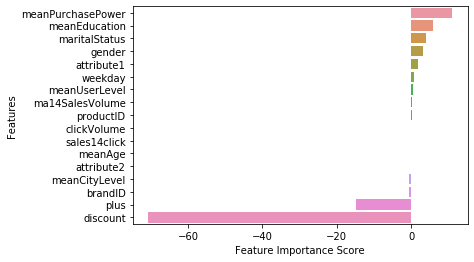

['meanPurchasePower',
 'meanEducation',
 'maritalStatus',
 'gender',
 'attribute1',
 'weekday',
 'meanUserLevel',
 'ma14SalesVolume',
 'productID',
 'clickVolume']

In [8]:
#feature importance in terms of coef
feature_imp = pd.Series(lr.coef_,index=X_train.columns).sort_values(ascending=False)
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()
top_10_features = feature_imp.iloc[:10]
top_10_features=(top_10_features.index).tolist()
top_10_features

## Standardization

In [9]:
ss=StandardScaler()
#drop categorical variable before standardization
X_temp=data.drop(['productID','brandID','attribute1','attribute2','weekday','sales'], axis=1)
y=data.sales
X_stan= ss.fit_transform(X_temp)
X_stan=pd.DataFrame(X_stan,columns=X_temp.columns)

#add back categorical variable
cat = data[['productID','brandID','attribute1','attribute2','weekday']]
X_stan = X_stan.join(cat)

#split data
X_stan_train,X_stan_test,y_train,y_test = train_test_split(X_stan,y, test_size=0.3,random_state =42)

#Use SLR again after standardization
lr_stan=LinearRegression()
lr_stan.fit(X_stan_train, y_train)
MSE(lr_stan.predict(X_stan_test),y_test)

2012.4806445392771

In [10]:
#R-squared
print(lr_stan.score(X_stan_train,y_train))
lr_stan.score(X_stan_test, y_test)

0.6214648042203774


0.8254385330910585

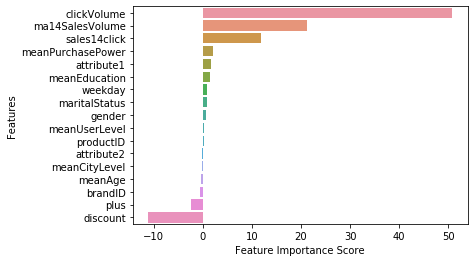

['clickVolume',
 'ma14SalesVolume',
 'sales14click',
 'meanPurchasePower',
 'attribute1',
 'meanEducation',
 'weekday',
 'maritalStatus',
 'gender',
 'meanUserLevel']

In [11]:
#feature importance after standardization
feature_imp = pd.Series(lr_stan.coef_,index=X_stan_train.columns).sort_values(ascending=False)
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

top_10_features = feature_imp.iloc[:10]
top_10_features=(top_10_features.index).tolist()
top_10_features

## SLR with Selected Features

In [12]:
#In order to obtain the smallest MSE, the following features are used
X=X_stan[['sales14click','clickVolume','meanEducation', 'meanPurchasePower','meanUserLevel','meanCityLevel','discount','brandID',
      'weekday'  
]]
y=data.sales
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state =42)
lr=LinearRegression()
lr.fit(X_train, y_train)
MSE(lr.predict(X_test),y_test)

1989.9794986221643

In [13]:
print(lr_stan.score(X_stan_train, y_train))
lr_stan.score(X_stan_test, y_test)

0.6214648042203774


0.8254385330910585

### The lowest MSE obtained from SLR is 1990.

# Lasso and Ridge Regression

In [14]:
#selected features from SLR
#X is already standardized
X = pd.get_dummies(X,drop_first=True)
y=data.sales

#split train and test
X_stan_train,X_stan_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state =42)

## Lasso tuning

In [15]:
def Lasso_KFold_MSE(alpha,k):
    kf = KFold(n_splits=k)
    MSE=[]
    for train_index, test_index in kf.split(X_stan):
        X_stan_train = X_stan.iloc[train_index]
        y_train = y.iloc[train_index]
        X_stan_test=X_stan.iloc[test_index]
        y_test=y.iloc[test_index]
        lasso=Lasso(alpha=alpha, max_iter=1e5)
        lasso.fit(X_stan_train, y_train)
        MSE.append(mean_squared_error(lasso.predict(X_stan_test),y_test))        
    return MSE   

In [16]:
ran=[0.01,0.1,1,5,10,50,100] 
MSE_vect = np.zeros(len(ran))
for i in range(len(ran)):
    MSE_vect[i] =  np.mean(Lasso_KFold_MSE(ran[i],10))
MSE_vect

array([3260.30200631, 3257.94924751, 3251.61982509, 3286.86648658,
       3433.28977681, 6069.02718713, 9902.79398938])

In [17]:
#alpha = 1
lasso=Lasso(alpha=1, max_iter=1e5)
lasso.fit(X_stan_train, y_train)
mean_squared_error(lasso.predict(X_stan_test),y_test)

2027.4189886313718

In [18]:
print(lasso.score(X_stan_train, y_train))
lasso.score(X_stan_test, y_test)

0.6028955187471903


0.8241427893208104

### The lowest MSE obtained from Lasso Regression is 2027.

## Ridge Tuning

In [19]:
#X_stan is standardized
#Contains all features
X = pd.get_dummies(X_stan,drop_first=True)
y=data.sales

#split train and test
X_stan_train,X_stan_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state =42)

In [20]:
def Ridge_KFold_MSE(alpha,k):
    kf = KFold(n_splits=k)
    MSE=[]
    for train_index, test_index in kf.split(X_stan):
        X_stan_train = X_stan.iloc[train_index]
        y_train = y.iloc[train_index]
        X_stan_test=X_stan.iloc[test_index]
        y_test=y.iloc[test_index]
        ridge=Ridge(alpha=alpha, max_iter=1e5)
        ridge.fit(X_stan_train, y_train)
        MSE.append(mean_squared_error(ridge.predict(X_stan_test),y_test))        
    return MSE   

In [21]:
ran=[0.01,0.1,1,5,10,50,100,1000,2000] 
MSE_vect = np.zeros(len(ran))
for i in range(len(ran)):
    MSE_vect[i] =  np.mean(Ridge_KFold_MSE(ran[i],10))
MSE_vect

array([3260.57633761, 3260.50340563, 3259.77807732, 3256.64061401,
       3252.90975251, 3229.52723273, 3212.25537845, 3387.52262124,
       3749.5516442 ])

In [22]:
ridge = Ridge(alpha=100)
ridge.fit(X_stan_train, y_train)
mean_squared_error(ridge.predict(X_stan_test),y_test)

2071.793957149465

In [23]:
print(ridge.score(X_stan_train, y_train))
ridge.score(X_stan_test, y_test)

0.6317045332981528


0.8202937288989997

### The lowest MSE obtained from Ridge Regression is 2072.

# RandomForest Regressor

## RF without K-fold to tune parameter

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [25]:
train=pd.read_csv('Data-train.csv',index_col=0)
X=train
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X['productID_str']=X['productID'].astype(str)
X['brandID_str']=X['brandID'].astype(str)
X['productID_str']=X['productID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday'] = X.apply(lambda x: (X['weekday']<5).astype(int))
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['productID','brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
X.head()

,clickVolume,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,...,attribute2_str_100.0,attribute2_str_30.0,attribute2_str_40.0,attribute2_str_50.0,attribute2_str_60.0,attribute2_str_70.0,attribute2_str_80.0,attribute2_str_90.0,weekday_str_0,weekday_str_1
0,2418.0,56.928571,31.694915,0.338983,2.929825,0.431034,0.269841,2.120690,3.079365,1.943396,...,1,0,0,0,0,0,0,0,1,0
1,1723.0,49.285714,30.652174,0.217391,2.928571,0.604651,0.191489,2.302326,2.446809,2.093023,...,1,0,0,0,0,0,0,0,1,0
2,1666.0,48.857143,31.370370,0.148148,2.941176,0.519231,0.357143,2.153846,2.839286,2.104167,...,1,0,0,0,0,0,0,0,0,1
3,386.0,19.714286,32.222222,0.333333,3.111111,0.333333,0.272727,2.444444,2.700000,2.888889,...,0,0,0,0,0,0,1,0,0,1
4,1419.0,66.214286,31.020408,0.183673,2.978723,0.425532,0.218182,2.468085,2.490909,2.042553,...,1,0,0,0,0,0,0,0,0,1


In [26]:
XX=X.drop('sales',axis=1)
yy=X['sales']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy,train_size=int(0.7*len(XX)), random_state=42)

### MSE and R-sqr before tuning

In [27]:
rfr=RandomForestRegressor(random_state=31, max_features=None,oob_score=True)
rfr.fit(XX_train,yy_train)
y_true = yy_test
y_pred = rfr.predict(XX_test)
print('Test MSE =',MSE(rfr.predict(XX_test),yy_test))
print('R2 =',r2_score(y_true, y_pred))

Test MSE = 1887.0484836898397
R2 = 0.8363184499016119


### Feature Importance

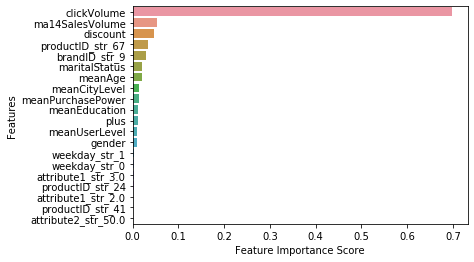

In [28]:
import pandas as pd
feature_imp = pd.Series(rfr.feature_importances_,index=XX_train.columns).sort_values(ascending=False)

import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

In [29]:
top_10_features = feature_imp.iloc[:10]
top_10_features=(top_10_features.index).tolist()
top_10_features

['clickVolume',
 'ma14SalesVolume',
 'discount',
 'productID_str_67',
 'brandID_str_9',
 'maritalStatus',
 'meanAge',
 'meanCityLevel',
 'meanPurchasePower',
 'meanEducation']

### reduced features dataset

In [30]:
# brandID, attribute1 and 2 remain
new_train = train[['clickVolume','ma14SalesVolume','avgOriginalUnitPrice','avgFinalUnitPrice','productID','brandID','maritalStatus','meanAge','meanCityLevel','meanPurchasePower','meanEducation','sales']]
new_train.head()
X_new=new_train
X_new['discount']=1-(X_new['avgOriginalUnitPrice']-X_new['avgFinalUnitPrice'])/X_new['avgOriginalUnitPrice']
X_new=X_new.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X_new['brandID_str']=X_new['brandID'].astype(str)
X_new['productID_str']=X_new['productID'].astype(str)
# X_new['weekday'] = X_new.apply(lambda x: X_new['weekday']<5)
# X_new['weekday_str']=X_new['weekday'].astype(str)
X_new=X_new.drop(['brandID','productID'],axis=1)
X_new=pd.get_dummies(X_new)
XX_new=X_new.drop('sales',axis=1)
yy_new=new_train['sales']
XX_new_train, XX_new_test, yy_new_train, yy_new_test = train_test_split(XX_new,yy_new,train_size=int(0.7*len(XX_new)), random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### MSE and R-sqr after reducing features

In [31]:
rf2=RandomForestRegressor(random_state=31,max_features=None,oob_score=True)
rf2.fit(XX_new_train,yy_new_train)
y_true = yy_new_test
y_pred = rf2.predict(XX_new_test)
print('Test MSE =',MSE(rf2.predict(XX_new_test),yy_new_test))
print('R2 =',r2_score(y_true, y_pred))

Test MSE = 1915.1651155080212
R2 = 0.8338796286846039


### Parameter Tuning -- Max_depth

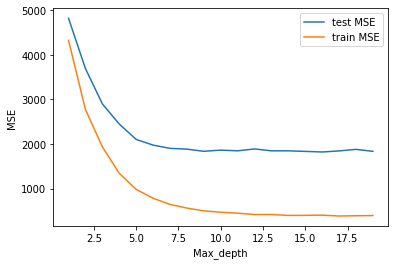

In [32]:
def MSE_rf(depth):
    rf=RandomForestRegressor(random_state=31,max_depth=depth,max_features=None,oob_score=True)
    rf.fit(XX_new_train,yy_new_train)
    mse_test = MSE(rf.predict(XX_new_test),yy_new_test)
    mse_train = MSE(rf.predict(XX_new_train),yy_new_train)
    return mse_test,mse_train

max_depth = [i for i in range(1,20)]
# max_depth = np.linspace(0, 10, num=10, endpoint=True, retstep=False, dtype=None, axis=0)
mse_vect_test= []
mse_vect_train= []
for i in max_depth:
    mse_vect_test.append(MSE_rf(i)[0])
    mse_vect_train.append(MSE_rf(i)[1])    
plt.plot(max_depth,mse_vect_test,label='test MSE')
plt.plot(max_depth,mse_vect_train,label='train MSE')
plt.xlabel('Max_depth')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best max_depth

In [33]:
index = np.argmin(mse_vect_test)
best_max_depth = max_depth[index]
corresponding_test_mse = mse_vect_test[index]
print('best_max_depth',best_max_depth)
print('corresponding_test_mse',corresponding_test_mse)

best_max_depth 16
corresponding_test_mse 1820.1887117722965


### Parameter Tuning -- min_samples_leaf

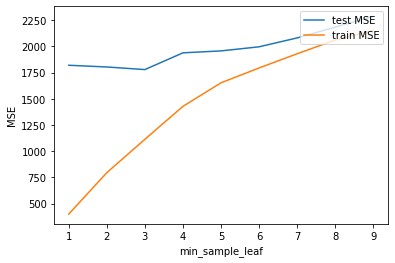

In [34]:
def MSE_rf(leaf):
    rf=RandomForestRegressor(random_state=31,max_depth = best_max_depth,min_samples_leaf=leaf,max_features=None,oob_score=True)
    rf.fit(XX_new_train,yy_new_train)
    mse_test = MSE(rf.predict(XX_new_test),yy_new_test)
    mse_train = MSE(rf.predict(XX_new_train),yy_new_train)
    return mse_test,mse_train

min_sample_leaf = [i for i in range(1,10)]
# max_depth = np.linspace(0, 10, num=10, endpoint=True, retstep=False, dtype=None, axis=0)
mse_vect_test= []
mse_vect_train= []
for i in min_sample_leaf:
    mse_vect_test.append(MSE_rf(i)[0])
    mse_vect_train.append(MSE_rf(i)[1])    
plt.plot(min_sample_leaf,mse_vect_test,label='test MSE')
plt.plot(min_sample_leaf,mse_vect_train,label='train MSE')
plt.xlabel('min_sample_leaf')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best min_sample_leaf

In [35]:
index = np.argmin(mse_vect_test)
best_min_sample_leaf = min_sample_leaf[index]
corresponding_test_mse = mse_vect_test[index]
print('best_min_sample_leaf',best_min_sample_leaf)
print('corresponding_test_mse',corresponding_test_mse)

best_min_sample_leaf 3
corresponding_test_mse 1779.0535401484924


### Parameter Tuning -- n_estimators

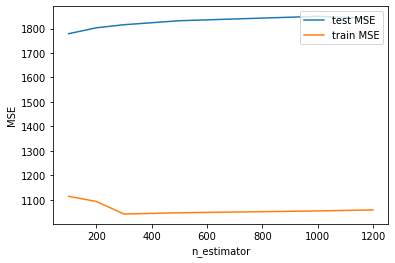

In [36]:
def MSE_rf(estimator):
    rf=RandomForestRegressor(random_state=31,n_estimators = estimator,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,max_features=None,oob_score=True)
    rf.fit(XX_new_train,yy_new_train)
    mse_test = MSE(rf.predict(XX_new_test),yy_new_test)
    mse_train = MSE(rf.predict(XX_new_train),yy_new_train)
    return mse_test,mse_train

n_estimator = [100,200,300,500,1000,1200]
mse_vect_test= []
mse_vect_train= []
for i in n_estimator:
    mse_vect_test.append(MSE_rf(i)[0])
    mse_vect_train.append(MSE_rf(i)[1])    
plt.plot(n_estimator,mse_vect_test,label='test MSE')
plt.plot(n_estimator,mse_vect_train,label='train MSE')
plt.xlabel('n_estimator')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best n_estimators

In [37]:
index = np.argmin(mse_vect_test)
best_n_estimator = n_estimator[index]
corresponding_test_mse = mse_vect_test[index]
print('best_n_estimator',best_n_estimator)
print('corresponding_test_mse',corresponding_test_mse)

best_n_estimator 100
corresponding_test_mse 1779.0535401484924


### Parameter Tuning -- ccp_alpha

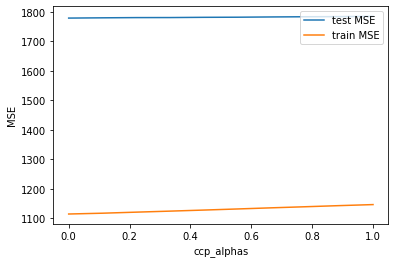

In [38]:
def MSE_rf(alpha):
    rf=RandomForestRegressor(random_state=31,ccp_alpha = alpha,n_estimators = best_n_estimator,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,max_features=None,oob_score=True)
    rf.fit(XX_new_train,yy_new_train)
    mse_test = MSE(rf.predict(XX_new_test),yy_new_test)
    mse_train = MSE(rf.predict(XX_new_train),yy_new_train)
    return mse_test,mse_train


ccp_alphas = np.linspace(0, 1, num=10, endpoint=True, retstep=False, axis=0)
mse_vect_test= []
mse_vect_train= []
for i in ccp_alphas:
    mse_vect_test.append(MSE_rf(i)[0])
    mse_vect_train.append(MSE_rf(i)[1])    
plt.plot(ccp_alphas,mse_vect_test,label='test MSE')
plt.plot(ccp_alphas,mse_vect_train,label='train MSE')
plt.xlabel('ccp_alphas')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best ccp_alpha

In [39]:
index = np.argmin(mse_vect_test)
best_ccp_alphas = ccp_alphas[index]
corresponding_test_mse = mse_vect_test[index]
print('best_ccp_alphas',best_ccp_alphas)
print('corresponding_test_mse',corresponding_test_mse)

best_ccp_alphas 0.0
corresponding_test_mse 1779.0535401484924


### After Tuning MSE and R-sqr

In [40]:
rf_final=RandomForestRegressor(random_state=31,n_estimators = best_n_estimator,ccp_alpha=best_ccp_alphas,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,\
                               max_features=None,oob_score=True)
rf_final.fit(XX_new_train,yy_new_train)
y_true = yy_new_test
y_pred = rf_final.predict(XX_new_test)
print('Test MSE =',MSE(rf_final.predict(XX_new_test),yy_new_test))
print('R2 =',r2_score(y_true, y_pred))

Test MSE = 1779.0535401484924
R2 = 0.8456858720502317


## RF with K-fold to tune parameter

In [41]:
new_train = train[['clickVolume','ma14SalesVolume','avgOriginalUnitPrice','avgFinalUnitPrice','productID','brandID','meanAge','meanCityLevel','meanPurchasePower','meanEducation','sales']]
new_train.head()
X_new=new_train
X_new['discount']=1-(X_new['avgOriginalUnitPrice']-X_new['avgFinalUnitPrice'])/X_new['avgOriginalUnitPrice']
X_new=X_new.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X_new['brandID_str']=X_new['brandID'].astype(str)
X_new['productID_str']=X_new['productID'].astype(str)
X_new=X_new.drop(['brandID','productID'],axis=1)
X_new=pd.get_dummies(X_new)
XX_new=X_new.drop('sales',axis=1)
yy_new=new_train['sales']
data_new=pd.DataFrame(XX_new)
data_new['sales']=yy_new
data_new.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,clickVolume,ma14SalesVolume,meanAge,meanCityLevel,meanPurchasePower,meanEducation,discount,brandID_str_10,brandID_str_11,brandID_str_12,...,productID_str_70,productID_str_71,productID_str_72,productID_str_73,productID_str_74,productID_str_75,productID_str_76,productID_str_8,productID_str_9,sales
0,2418.0,56.928571,31.694915,1.943396,2.120690,2.929825,0.777015,0,0,0,...,0,0,0,0,0,0,0,0,0,82
1,1723.0,49.285714,30.652174,2.093023,2.302326,2.928571,0.741343,0,0,0,...,0,0,0,0,0,0,0,0,0,48
2,1666.0,48.857143,31.370370,2.104167,2.153846,2.941176,0.719499,0,0,0,...,0,0,0,0,0,0,0,0,0,56
3,386.0,19.714286,32.222222,2.888889,2.444444,3.111111,0.581755,0,0,0,...,0,0,0,0,0,0,0,0,0,17
4,1419.0,66.214286,31.020408,2.042553,2.468085,2.978723,0.734709,0,0,0,...,0,0,0,0,0,0,0,0,0,61


### Parameter Tuning -- Max_depth

In [42]:
from sklearn.model_selection import KFold

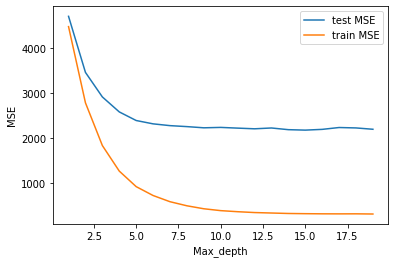

In [43]:
def MSE_rf(depth):
    rf=RandomForestRegressor(random_state=31,max_depth=depth,max_features=None,oob_score=True)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

max_depth = [i for i in range(1,20)]
# max_depth = np.linspace(0, 10, num=10, endpoint=True, retstep=False, dtype=None, axis=0)
mse_vect_test= []
mse_vect_train= []
for i in max_depth:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    
    
plt.plot(max_depth,mse_vect_test,label='test MSE')
plt.plot(max_depth,mse_vect_train,label='train MSE')
plt.xlabel('Max_depth')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best max_depth

In [44]:
index = np.argmin(mse_vect_test)
best_max_depth = max_depth[index]
corresponding_test_mse = mse_vect_test[index]
print('best_max_depth',best_max_depth)
print('corresponding_test_mse',corresponding_test_mse)

best_max_depth 15
corresponding_test_mse 2176.9652347142332


### Parameter Tuning -- min_samples_leaf

In [45]:
def MSE_rf(leaf):
    rf=RandomForestRegressor(random_state=31,max_depth = best_max_depth,min_samples_leaf=leaf,max_features=None,oob_score=True)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

min_sample_leaf = [i for i in range(1,10)]
mse_vect_test= []
mse_vect_train= []
for i in min_sample_leaf:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    

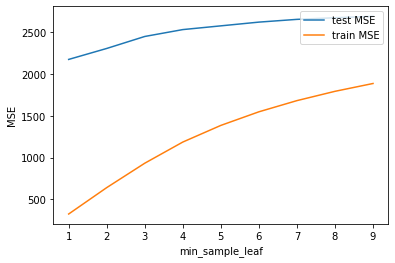

In [46]:
plt.plot(min_sample_leaf,mse_vect_test,label='test MSE')
plt.plot(min_sample_leaf,mse_vect_train,label='train MSE')
plt.xlabel('min_sample_leaf')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best min_sample_leaf

In [47]:
index = np.argmin(mse_vect_test)
best_min_sample_leaf = min_sample_leaf[index]
corresponding_test_mse = mse_vect_test[index]
print('best_min_sample_leaf',best_min_sample_leaf)
print('corresponding_test_mse',corresponding_test_mse)

best_min_sample_leaf 1
corresponding_test_mse 2176.9652347142332


### Parameter Tuning -- n_estimators

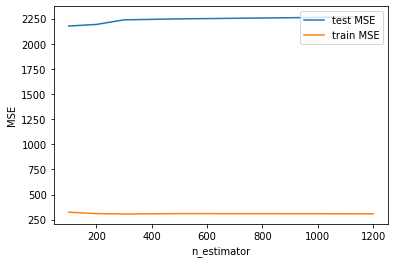

In [48]:
def MSE_rf(estimator):
    rf=RandomForestRegressor(random_state=31,n_estimators = estimator,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,max_features=None,oob_score=True)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

n_estimator = [100,200,300,500,1000,1200]
mse_vect_test= []
mse_vect_train= []
for i in n_estimator:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    
    
plt.plot(n_estimator,mse_vect_test,label='test MSE')
plt.plot(n_estimator,mse_vect_train,label='train MSE')
plt.xlabel('n_estimator')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best n_estimators

In [49]:
index = np.argmin(mse_vect_test)
best_n_estimator = n_estimator[index]
corresponding_test_mse = mse_vect_test[index]
print('best_n_estimator',best_n_estimator)
print('corresponding_test_mse',corresponding_test_mse)

best_n_estimator 100
corresponding_test_mse 2176.9652347142332


### Parameter Tuning -- ccp_alpha

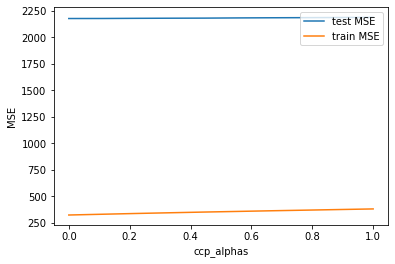

In [50]:
def MSE_rf(alpha):
    rf=RandomForestRegressor(random_state=31,ccp_alpha = alpha,n_estimators = best_n_estimator,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,max_features=None,oob_score=True)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

ccp_alphas = np.linspace(0, 1, num=10, endpoint=True, retstep=False, axis=0)
mse_vect_test= []
mse_vect_train= []
for i in ccp_alphas:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])
    
plt.plot(ccp_alphas,mse_vect_test,label='test MSE')
plt.plot(ccp_alphas,mse_vect_train,label='train MSE')
plt.xlabel('ccp_alphas')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### Best ccp_alpha

In [51]:
index = np.argmin(mse_vect_test)
best_ccp_alphas = ccp_alphas[index]
corresponding_test_mse = mse_vect_test[index]
print('best_ccp_alphas',best_ccp_alphas)
print('corresponding_test_mse',corresponding_test_mse)

best_ccp_alphas 0.0
corresponding_test_mse 2176.9652347142332


### After Tuning MSE and R-sqr

In [52]:
rf_final=RandomForestRegressor(random_state=31,n_estimators = best_n_estimator,ccp_alpha=best_ccp_alphas,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,\
                               max_features=None,oob_score=True)
rf_final.fit(XX_new_train,yy_new_train)
y_true = yy_new_test
y_pred = rf_final.predict(XX_new_test)
print('Test MSE =',MSE(rf_final.predict(XX_new_test),yy_new_test))
print('R2 =',r2_score(y_true, y_pred))

Test MSE = 1833.2270991048747
R2 = 0.8409868872700481


### Using K-fold to find average Train and Test MSE

In [53]:
rf_final=RandomForestRegressor(random_state=31,n_estimators = best_n_estimator,ccp_alpha=best_ccp_alphas,max_depth = best_max_depth,min_samples_leaf=best_min_sample_leaf,max_features=None,oob_score=True)
kf = KFold(n_splits=5)
mse_train=[]
mse_test=[]
for train_index, test_index in kf.split(data_new):
    data_new_train = data_new.iloc[train_index]
    data_new_test=data_new.iloc[test_index]
    rf_final.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
    mse_train.append(MSE(rf_final.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
    mse_test.append(MSE(rf_final.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
print('Train MSE =',np.mean(mse_train),'Test MSE =',np.mean(mse_test))

Train MSE = 324.72457791412535 Test MSE = 2176.9652347142332


# Gradient Boosting Regressor

## GBR Feature Selection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

In [3]:
train=pd.read_csv('Data-train.csv',index_col=0)

### Variation 1: all parametres, MSE 1501

In [4]:
X=train.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
X.head()

,clickVolume,ma14SalesVolume,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,...,attribute2_str_70.0,attribute2_str_80.0,attribute2_str_90.0,weekday_str_1,weekday_str_2,weekday_str_3,weekday_str_4,weekday_str_5,weekday_str_6,weekday_str_7
0,2418.0,56.928571,31.694915,0.338983,2.929825,0.431034,0.269841,2.120690,3.079365,1.943396,...,0,0,0,0,0,0,0,1,0,0
1,1723.0,49.285714,30.652174,0.217391,2.928571,0.604651,0.191489,2.302326,2.446809,2.093023,...,0,0,0,0,0,0,0,0,1,0
2,1666.0,48.857143,31.370370,0.148148,2.941176,0.519231,0.357143,2.153846,2.839286,2.104167,...,0,0,0,0,0,0,1,0,0,0
3,386.0,19.714286,32.222222,0.333333,3.111111,0.333333,0.272727,2.444444,2.700000,2.888889,...,0,1,0,0,0,0,1,0,0,0
4,1419.0,66.214286,31.020408,0.183673,2.978723,0.425532,0.218182,2.468085,2.490909,2.042553,...,0,0,0,0,0,0,1,0,0,0


In [5]:
XX=X.drop('sales',axis=1)
yy=X['sales']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy,train_size=int(0.7*len(XX)), random_state=42)
print(len(XX_train))
len(XX_test)

1743


748

In [6]:
gbr = GradientBoostingRegressor(random_state=31)
gbr.fit(XX_train,yy_train)
MSE(gbr.predict(XX_test),yy_test)

1501.2284142745616

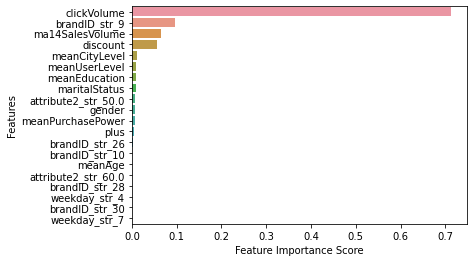

In [7]:
feature_imp = pd.Series(gbr.feature_importances_,index=XX_train.columns).sort_values(ascending=False)

import seaborn as sns

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

### Variation 2: exclude 'meanAge','maritalStatus','meanUserLevel', MSE 1450

In [8]:
X=train.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
XX=X.drop('sales',axis=1)
yy=X['sales']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy,train_size=int(0.7*len(XX)), random_state=42)

In [9]:
gbr = GradientBoostingRegressor(random_state=31)
gbr.fit(XX_train,yy_train)

GradientBoostingRegressor(random_state=31)

In [10]:
MSE(gbr.predict(XX_test),yy_test)

1450.8626806683774

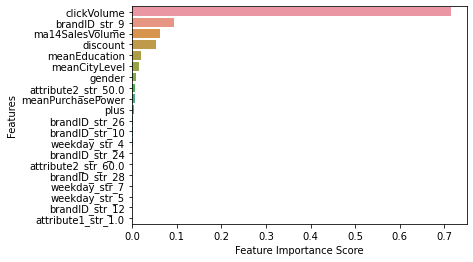

In [11]:
feature_imp = pd.Series(gbr.feature_importances_,index=XX_train.columns).sort_values(ascending=False)

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp[:20].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

### Variation 3:exclude 'brandID' 'meanAge','maritalStatus','meanUserLevel', MSE 1633

In [12]:
X=train.drop(['productID','brandID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)

XX=X.drop('sales',axis=1)
yy=X['sales']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy,train_size=int(0.7*len(XX)), random_state=42)

gbr.fit(XX_train,yy_train)
MSE(gbr.predict(XX_test),yy_test)

1633.1782387308085

### Conclusion on attribute selection:  Variation 2 gave the smallest MSE. We should exclude attributes 'meanAge','maritalStatus','meanUserLevel', and include a new attribute 'discount'


## Parametre Tuning with variation 2

In [13]:
X=train.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
XX=X.drop('sales',axis=1)
yy=X['sales']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy,train_size=int(0.7*len(XX)), random_state=42)

gbr = GradientBoostingRegressor(random_state=31)
gbr.fit(XX_train,yy_train)
MSE(gbr.predict(XX_test),yy_test)

1450.8626806683774

Base model gave a MSE=1450. Parameter tuning will be performed upon the base model.

### learning_rate

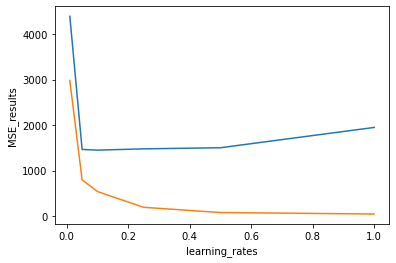

In [14]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_mse = []
test_mse = []
for item in learning_rates:
    model = GradientBoostingRegressor(random_state=31,learning_rate=item)
    model.fit(XX_train, yy_train)
    train_mse.append(MSE(model.predict(XX_train),yy_train))
    test_mse.append(MSE(model.predict(XX_test),yy_test))
    
from matplotlib.legend_handler import HandlerLine2D
plt.plot(learning_rates, test_mse, label='test MSE')
plt.plot(learning_rates, train_mse,label='train MSE')
plt.ylabel('MSE_results')
plt.xlabel('learning_rates')
plt.show()

Result: 0.01 is the optimal learning rate.

### N_estimators

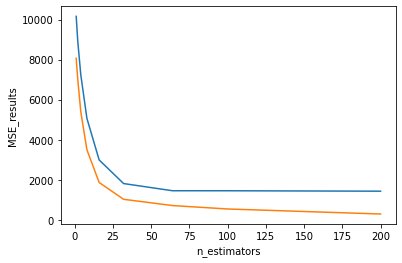

In [15]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_mse = []
test_mse = []
for item in n_estimators:
    model = GradientBoostingRegressor(random_state=31,n_estimators=item)
    model.fit(XX_train, yy_train)
    train_mse.append(MSE(model.predict(XX_train),yy_train))
    test_mse.append(MSE(model.predict(XX_test),yy_test))
    
plt.plot(n_estimators, test_mse, label='test MSE')
plt.plot(n_estimators, train_mse,label='train MSE')
plt.ylabel('MSE_results')
plt.xlabel('n_estimators')
plt.show()

Increasing the number of estimators may result in overfitting also. In our case, using 64 trees is optimal.

## max_depth

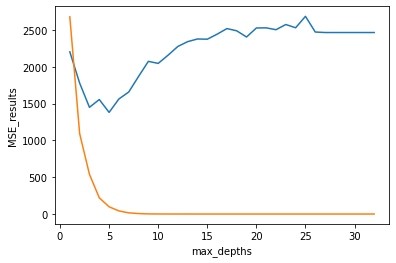

In [16]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_mse = []
test_mse = []
for item in max_depths:
    model = GradientBoostingRegressor(random_state=31,max_depth=item)
    model.fit(XX_train, yy_train)
    train_mse.append(MSE(model.predict(XX_train),yy_train))
    test_mse.append(MSE(model.predict(XX_test),yy_test))
    
plt.plot(max_depths, test_mse, label='test MSE')
plt.plot(max_depths, train_mse,label='train MSE')
plt.ylabel('MSE_results')
plt.xlabel('max_depths')
plt.show()


In our case, using depth=5 is optimal.

## max_features


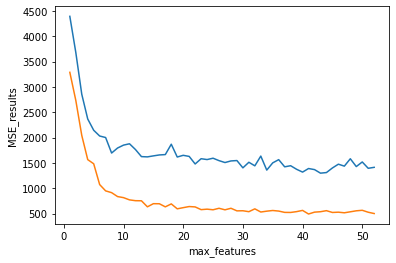

In [17]:
max_features = list(range(1,XX.shape[1]))
train_mse = []
test_mse = []

for item in max_features:
   model = GradientBoostingRegressor(random_state=31,max_features=item)
   model.fit(XX_train, yy_train)
   train_mse.append(MSE(model.predict(XX_train),yy_train))
   test_mse.append(MSE(model.predict(XX_test),yy_test))
    
plt.plot(max_features, test_mse, label='test MSE')
plt.plot(max_features, train_mse,label='train MSE')
plt.ylabel('MSE_results')
plt.xlabel('max_features')
plt.show()

As the graph does not converge, there is no best max_features

## After tuning: New Model with MSE1400

In [18]:
XX=X.drop('sales',axis=1)
yy=X['sales']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy,train_size=int(0.7*len(XX)), random_state=42)
gbr = GradientBoostingRegressor(random_state=31,learning_rate=0.1,n_estimators=64,max_depth=5)
gbr.fit(XX_train,yy_train)
MSE(gbr.predict(XX_test),yy_test)

1399.985198478923

In [19]:
from sklearn.metrics import r2_score
y_true = yy_test
y_pred = gbr.predict(XX_test)
r2_score(y_true, y_pred)

0.878566052021219

This model explained 88% of the variation.

## GBR with K-fold to tune parameter

In [20]:
X=train.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
XX=X.drop('sales',axis=1)
yy=X['sales']
data_new = pd.concat([XX,yy],axis=1)
data_new.head()

,clickVolume,ma14SalesVolume,gender,meanEducation,plus,meanPurchasePower,meanCityLevel,discount,brandID_str_10,brandID_str_11,...,attribute2_str_80.0,attribute2_str_90.0,weekday_str_1,weekday_str_2,weekday_str_3,weekday_str_4,weekday_str_5,weekday_str_6,weekday_str_7,sales
0,2418.0,56.928571,0.338983,2.929825,0.269841,2.120690,1.943396,0.777015,0,0,...,0,0,0,0,0,0,1,0,0,82
1,1723.0,49.285714,0.217391,2.928571,0.191489,2.302326,2.093023,0.741343,0,0,...,0,0,0,0,0,0,0,1,0,48
2,1666.0,48.857143,0.148148,2.941176,0.357143,2.153846,2.104167,0.719499,0,0,...,0,0,0,0,0,1,0,0,0,56
3,386.0,19.714286,0.333333,3.111111,0.272727,2.444444,2.888889,0.581755,0,0,...,1,0,0,0,0,1,0,0,0,17
4,1419.0,66.214286,0.183673,2.978723,0.218182,2.468085,2.042553,0.734709,0,0,...,0,0,0,0,0,1,0,0,0,61


### learning_rate with K-Fold

In [21]:
from sklearn.model_selection import KFold

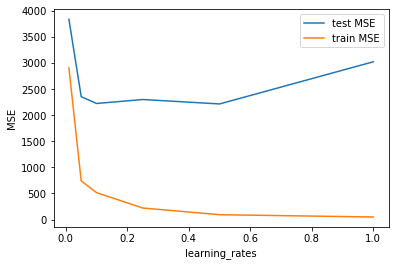

In [22]:
def MSE_rf(item):
    rf=GradientBoostingRegressor(random_state=31,learning_rate=item)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
mse_vect_test= []
mse_vect_train= []
for i in learning_rates:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    
    
plt.plot(learning_rates,mse_vect_test,label='test MSE')
plt.plot(learning_rates,mse_vect_train,label='train MSE')
plt.xlabel('learning_rates')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### N_estimators with K-Fold

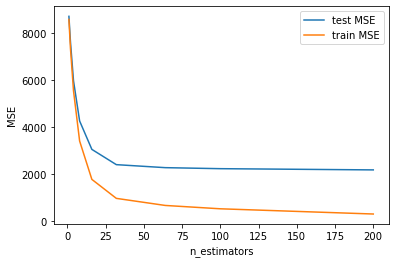

In [23]:
def MSE_rf(item):
    rf=GradientBoostingRegressor(random_state=31,n_estimators=item)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
mse_vect_test= []
mse_vect_train= []
for i in n_estimators:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    
    
plt.plot(n_estimators,mse_vect_test,label='test MSE')
plt.plot(n_estimators,mse_vect_train,label='train MSE')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### max_depth with K-Fold

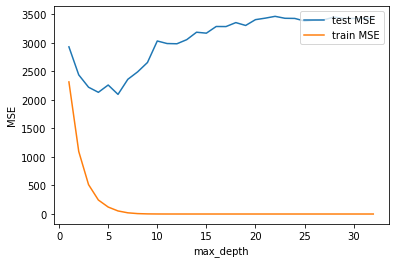

In [43]:
def MSE_rf(item):
    rf=GradientBoostingRegressor(random_state=31,max_depth=item)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

max_depths = np.linspace(1, 32, 32, endpoint=True)
mse_vect_test= []
mse_vect_train= []
for i in max_depths:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    
    
plt.plot(max_depths,mse_vect_test,label='test MSE')
plt.plot(max_depths,mse_vect_train,label='train MSE')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

### max_features with K-Fold

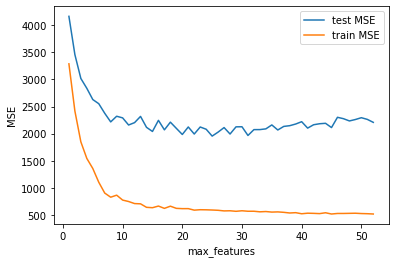

In [44]:
def MSE_rf(item):
    rf=GradientBoostingRegressor(random_state=31,max_features=item)
    kf = KFold(n_splits=5)
    mse_train=[]
    mse_test=[]
    for train_index, test_index in kf.split(data_new):
        data_new_train = data_new.iloc[train_index]
        data_new_test=data_new.iloc[test_index]
        rf.fit(data_new_train.iloc[:,:-1],data_new_train['sales'])
        mse_train.append(MSE(rf.predict(data_new_train.iloc[:,:-1]),data_new_train['sales']))
        mse_test.append(MSE(rf.predict(data_new_test.iloc[:,:-1]),data_new_test['sales'])) 
    return np.mean(mse_train),np.mean(mse_test)

max_features = list(range(1,XX.shape[1]))
mse_vect_test= []
mse_vect_train= []
for i in max_features:
    mse_vect_test.append(MSE_rf(i)[1])
    mse_vect_train.append(MSE_rf(i)[0])    
    
plt.plot(max_features,mse_vect_test,label='test MSE')
plt.plot(max_features,mse_vect_train,label='train MSE')
plt.xlabel('max_features')
plt.ylabel('MSE')
plt.legend(loc=1)
plt.show()

The parametre tuning with KFold method gave the same results as the one without KFold method

# SVM

In [46]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [47]:
train=pd.read_csv('Data-train.csv',index_col=0)
test=pd.read_csv('Data-test.csv',index_col=0)
data= pd.concat([train,test])
print(data.shape,train.shape,test.shape)

(4148, 18) (2491, 18) (1657, 17)


In [50]:
X=data.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
X.head()

,clickVolume,ma14SalesVolume,gender,meanEducation,plus,meanPurchasePower,meanCityLevel,sales,discount,brandID_str_10,...,attribute2_str_70.0,attribute2_str_80.0,attribute2_str_90.0,weekday_str_1,weekday_str_2,weekday_str_3,weekday_str_4,weekday_str_5,weekday_str_6,weekday_str_7
0,2418.0,56.928571,0.338983,2.929825,0.269841,2.120690,1.943396,82.0,0.777015,0,...,0,0,0,0,0,0,0,1,0,0
1,1723.0,49.285714,0.217391,2.928571,0.191489,2.302326,2.093023,48.0,0.741343,0,...,0,0,0,0,0,0,0,0,1,0
2,1666.0,48.857143,0.148148,2.941176,0.357143,2.153846,2.104167,56.0,0.719499,0,...,0,0,0,0,0,0,1,0,0,0
3,386.0,19.714286,0.333333,3.111111,0.272727,2.444444,2.888889,17.0,0.581755,0,...,0,1,0,0,0,0,1,0,0,0
4,1419.0,66.214286,0.183673,2.978723,0.218182,2.468085,2.042553,61.0,0.734709,0,...,0,0,0,0,0,0,1,0,0,0


standardize the csv
<br>note y should not be standardized

In [48]:
ss=StandardScaler(with_mean=False)

In [51]:
XX=X.drop('sales',axis=1)
yy=X['sales']
XX= ss.fit_transform(XX)

In [52]:
TrainX = XX[:2490,:]
Trainy = yy[:2490]
print(TrainX.shape,Trainy.shape)
data = pd.concat([pd.DataFrame(TrainX),pd.DataFrame(Trainy)],axis=1)

(2490, 53) (2490,)


linear, C = 100

In [54]:
TrainX_train, TrainX_test, Trainy_train, Trainy_test = train_test_split(TrainX,Trainy,train_size=int(0.7*len(TrainX)), random_state=42)

In [55]:
clf1 = SVR(C=100, kernel='linear')
clf1.fit(TrainX_train,Trainy_train)
MSE(clf1.predict(TrainX_test),Trainy_test)

1077.1549537126118

radial, C=54

In [57]:
clf4 = SVR()
clf4.fit(TrainX_train,Trainy_train)
MSE(clf4.predict(TrainX_test),Trainy_test)

7284.938186360635

radial, C=100

In [58]:
clf2 = SVR(C=100, kernel='rbf')
clf2.fit(TrainX_train,Trainy_train)
MSE(clf2.predict(TrainX_test),Trainy_test)

1344.567779490386

radial, C=200 (as C increases, MSE drops)

In [59]:
clf5 = SVR(C=200, kernel='rbf')
clf5.fit(TrainX_train,Trainy_train)
MSE(clf5.predict(TrainX_test),Trainy_test)

1174.7834712205743

poly, degree=2

In [60]:
clf3 = SVR(C=100, kernel='poly', degree=2)
clf3.fit(TrainX_train,Trainy_train)
MSE(clf3.predict(TrainX_test),Trainy_test)

1147.9522368112455

poly, degree=3

In [61]:
clf6 = SVR(C=100, kernel='poly', degree=3)
clf6.fit(TrainX_train,Trainy_train)
MSE(clf6.predict(TrainX_test),Trainy_test)

1048.1870359454792

${R^2}$

In [65]:
from sklearn.metrics import r2_score
y_true = Trainy_test
y_pred = clf6.predict(TrainX_test)
r2 = r2_score(y_true, y_pred)
r2

0.8631744129045433

In [66]:
y_true = Trainy_test
y_pred = clf1.predict(TrainX_test)
r2 = r2_score(y_true, y_pred)
r2

0.8593930721518925

In [67]:
y_true = Trainy_test
y_pred = clf2.predict(TrainX_test)
r2 = r2_score(y_true, y_pred)
r2

0.8244862133288435

Now do the data processing on data-test

In [62]:
TestX = XX[2491:,:]
Testy = yy[2491:]
TestX.shape,Testy.shape

((1657, 53), (1657,))

In [63]:
results = clf6.predict(TestX)

In [64]:
results=pd.DataFrame(results)
results.describe()

,0
count,1657.000000
mean,48.498078
std,81.504152
min,-17.560977
25%,11.166680
50%,23.879035
75%,53.299039
max,1278.635480


Conclusion on SVM Models: The SVM model is not selected because it generates prediction up to -17 thus it is evaluated to be unstable.

# Sales Prediction and Inventory Decision with the best model (Gradient boosting)

In [27]:
X=train.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)
XX=X.drop('sales',axis=1)
yy=X['sales']

import the model with best parametres:

In [28]:
gbr = GradientBoostingRegressor(random_state=31,learning_rate=0.1,n_estimators=64,max_depth=5)

In [29]:
gbr.fit(XX,yy)

GradientBoostingRegressor(max_depth=5, n_estimators=64, random_state=31)

In [30]:
test=pd.read_csv('Data-test.csv',index_col=0)
test.head()

,productID,brandID,attribute1,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,weekday,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel
0,35,2,4.0,100.0,1772.0,118.00,57.293333,26.357143,5,29.411765,0.078431,3.148936,0.551020,0.307692,2.346939,2.596154,2.140000
1,52,32,3.0,100.0,837.0,250.00,250.000000,34.000000,2,27.142857,0.285714,3.285714,0.571429,0.285714,2.142857,3.285714,1.800000
2,23,25,3.0,100.0,596.0,69.90,59.900000,45.142857,7,33.333333,0.333333,2.500000,0.666667,0.200000,2.666667,2.000000,3.000000
3,49,25,3.0,80.0,726.0,139.90,83.212500,11.357143,3,25.333333,0.400000,3.000000,0.500000,0.200000,2.714286,2.400000,2.076923
4,4,25,3.0,70.0,1664.0,127.03,112.175000,29.428571,1,30.461538,0.346154,2.916667,0.423077,0.153846,2.423077,4.717949,1.840000


data processing on the test dataset

In [33]:
X=test.drop(['productID'], axis=1)
X['discount']=1-(X['avgOriginalUnitPrice']-X['avgFinalUnitPrice'])/X['avgOriginalUnitPrice']
X=X.drop(['avgOriginalUnitPrice','avgFinalUnitPrice'],axis=1)
X=X.drop(['meanAge','maritalStatus','meanUserLevel'],axis=1)
X['brandID_str']=X['brandID'].astype(str)
X['attribute1_str']=X['attribute1'].astype(str)
X['attribute2_str']=X['attribute2'].astype(str)
X['weekday_str']=X['weekday'].astype(str)
X=X.drop(['brandID','attribute1','attribute2','weekday'],axis=1)
X=pd.get_dummies(X)

In [34]:
pred_sales = np.rint(gbr.predict(X))
pred_sales

array([ 59.,  22.,  12., ..., 275.,  14.,  20.])

In [35]:
pred_sales = pd.DataFrame(pred_sales)
pred_sales = pred_sales.clip(lower=0, upper=None)

In [36]:
pred_sales.describe()

,0
count,1657.000000
mean,53.713941
std,87.651961
min,-0.000000
25%,12.000000
50%,24.000000
75%,57.000000
max,840.000000


Assume the sales will follow exponential distribuion

In [37]:
Price=20
Cost=12
salvage=8
Over=Cost-salvage
Under=Price-Cost

In [38]:
inventory=np.rint(-pred_sales * np.log(1 - Under/(Under + Over)))
inventory

,0
0,65.0
1,24.0
2,13.0
3,29.0
4,51.0
...,...
1652,27.0
1653,85.0
1654,302.0
1655,15.0


In [39]:
test['sales']=pred_sales
test['inventory']=inventory
test.head()

,productID,brandID,attribute1,attribute2,clickVolume,avgOriginalUnitPrice,avgFinalUnitPrice,ma14SalesVolume,weekday,meanAge,gender,meanEducation,maritalStatus,plus,meanPurchasePower,meanUserLevel,meanCityLevel,sales,inventory
0,35,2,4.0,100.0,1772.0,118.00,57.293333,26.357143,5,29.411765,0.078431,3.148936,0.551020,0.307692,2.346939,2.596154,2.140000,59.0,65.0
1,52,32,3.0,100.0,837.0,250.00,250.000000,34.000000,2,27.142857,0.285714,3.285714,0.571429,0.285714,2.142857,3.285714,1.800000,22.0,24.0
2,23,25,3.0,100.0,596.0,69.90,59.900000,45.142857,7,33.333333,0.333333,2.500000,0.666667,0.200000,2.666667,2.000000,3.000000,12.0,13.0
3,49,25,3.0,80.0,726.0,139.90,83.212500,11.357143,3,25.333333,0.400000,3.000000,0.500000,0.200000,2.714286,2.400000,2.076923,26.0,29.0
4,4,25,3.0,70.0,1664.0,127.03,112.175000,29.428571,1,30.461538,0.346154,2.916667,0.423077,0.153846,2.423077,4.717949,1.840000,46.0,51.0


In [40]:
test.to_csv('group22.csv')

In [41]:
profit = np.sum(test['sales'])*(Price -Cost) - np.sum(test['inventory']-test['sales'])*(Cost-salvage)
profit

677148.0